# 1. Contexto

\blindtext

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn as sk
import random
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier

# 2. Pré-Processamento

Vamos ver como é a "cara" do nosso dataset e se é necessário realizar alguma mudança nas variáveis. (Normalizar, criar flags, mudança de tipos, etc...)

In [2]:
df_original=pd.read_csv('train.csv').drop(columns='ID_code')
df=df_original.copy()
df.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [9]:
df[df.columns[3]]

0         11.9081
1         13.8588
2         12.0805
3          8.9522
4         12.8746
           ...   
199995     8.2622
199996    16.7052
199997    10.5127
199998    13.6104
199999    12.1183
Name: var_2, Length: 200000, dtype: float64

aa$a$

O dados estão anonimizados e, desta forma, não é possível realizar nenhuma análise qualitativa que, talvez, nos permitiria reduzir o número de variáveis. Talvez algum padrão nos valores distintos que cada variável assume pode nos fornecer mais informação. Mas, primeiro, vamos ver se os valores faltantes (missing values) nos dizem algo.

In [116]:
print(df.shape)
print("qtd de vals NA:", df.isna().sum().sum()) #None ou NaN
print("classes da target:", df['target'].unique())#valores que a target assume

(200000, 201)
qtd de vals NA: 0
classes da target: [0 1]


Ótimo, sem surpresas. A target é binária e não temos nenhum valor faltando (vamos analisar os valores que são 0 mais a frente, os valores faltantes podem ter sido substituídos por 0 em algum tratamento prévio). Vejamos agora se os datatypes são apropriados.

In [139]:
list(df.columns[df.dtypes != 'float64'])

['target']

Ok, todas as var_i são do tipo float64, sem surpresas novamente. Até esse ponto, não me parece necessário fazer nenhum ajuste.

Além disso, suspeito que uma PCA tenha sido aplicada, pela forma como os valores estão distribuídos. Na seção que segue, vamos verificar se este é o caso e avaliar se é viável fazer (mais) uma redução da dimensionalidade.

# 3. Análise Exploratória

Vamos começar contando a quantidade de valores repetidos, para cada variável. Talvez seja possível encontrar algum padrão que mereça atenção.

top 10 vars com menos valores repetidos

var_68       451
var_91      7962
var_108     8525
var_103     9376
var_12      9561
var_148    10608
var_161    11071
var_71     13527
var_25     14853
var_43     15188
dtype: int64


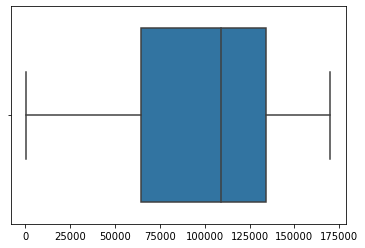

In [159]:
uniq=df.loc[:,'var_0':'var_199'].nunique()
print('top 10 vars com menos valores repetidos\n')
print(uniq.nsmallest(10))
sns.boxplot(x=uniq)
plt.show()

A maioria das variáveis possui mais de 100k valores distintos. Não seria apropriado inferir algo em cima disso, acredito que seria mais interessante ver a distribuição das variáveis ao invés. Por outro lado, as variáveis com poucos valores distintos podem "dividir bem" os dados, no sentido de que talvez seja possível "visualizar" essa separação.

Devido ao número elevado de variáveis, algumas opções de visualização não serão viáveis (e.g. PairGrid de scatterplots, podemos plotar alguns ao acaso).

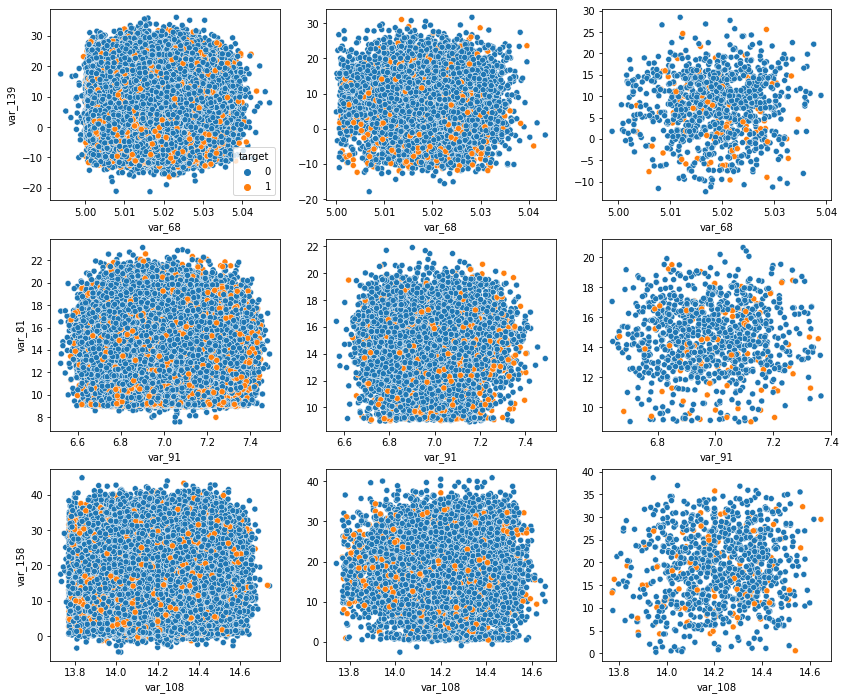

In [183]:
fig, axs = plt.subplots(figsize=(14,12),nrows=3,ncols=3)

subsamplekk=random.sample(range(0, 200000), 10000) #remove cluttering
subsamplek=random.sample(range(0, 200000), 1000)

sns.scatterplot(data=df, x='var_68',y='var_139', hue='target',ax=axs[0,0])
sns.scatterplot(data=df.iloc[subsamplekk,:], x='var_68',y='var_139', hue='target',ax=axs[0,1], legend=False)
axs[0,1].set_ylabel("")
sns.scatterplot(data=df.iloc[subsamplek,:], x='var_68',y='var_139', hue='target',ax=axs[0,2], legend=False)
axs[0,2].set_ylabel("")

sns.scatterplot(data=df, x='var_91',y='var_81', hue='target',ax=axs[1,0], legend=False)
sns.scatterplot(data=df.iloc[subsamplekk,:], x='var_91',y='var_81', hue='target',ax=axs[1,1], legend=False)
axs[1,1].set_ylabel("")
sns.scatterplot(data=df.iloc[subsamplek,:], x='var_91',y='var_81', hue='target',ax=axs[1,2], legend=False)
axs[1,2].set_ylabel("")

sns.scatterplot(data=df, x='var_108',y='var_158', hue='target',ax=axs[2,0], legend=False)
sns.scatterplot(data=df.iloc[subsamplekk,:], x='var_108',y='var_158', hue='target',ax=axs[2,1], legend=False)
axs[2,1].set_ylabel("")
sns.scatterplot(data=df.iloc[subsamplek,:], x='var_108',y='var_158', hue='target',ax=axs[2,2], legend=False)
axs[2,2].set_ylabel("")


plt.show()

Nada muito informativo, porém isso já era esperado. Entretanto, é possível notar que os intervalos dos valores são "bem definidos", por exemplo, para a var_158 pode-se notar uma queda abrupta na quantidade de exemplos tais que x[ 'var_158' ] $\leq$ 0. Bom, pelo menos para essas 6 variáveis, este é o caso.

Acho que o melhor seria "morder a bala" de uma vez e ver, finalmente, como são as distribuições das variáveis. Com "apenas" 200 colunas, ainda é viável fazer essa análise.

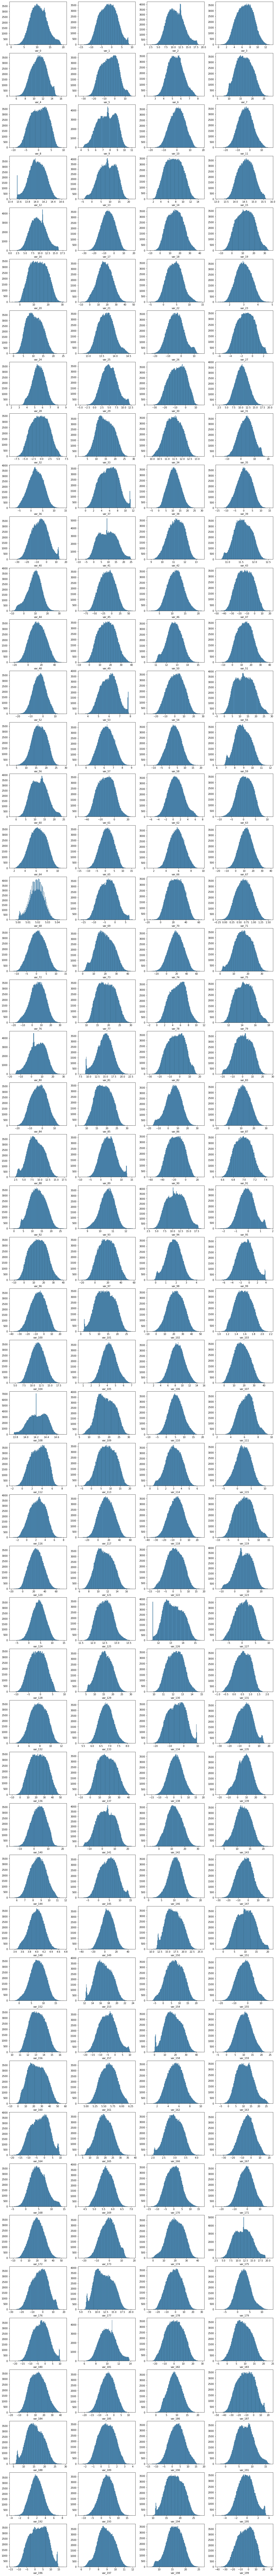

In [163]:
fig, axs = plt.subplots(figsize=(20,200),nrows=50,ncols=4)
for i in range(0,50):
    for j in range(0,4):
        sns.histplot(df[df.columns[i*4+j+1]],ax=axs[i,j]) #bins=auto
        axs[i,j].set_ylabel("")
plt.show()

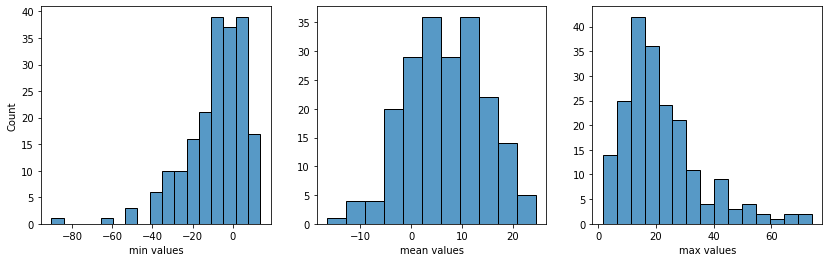

In [168]:
fig, axs = plt.subplots(figsize=(14,4),ncols=3)
sns.histplot(df.loc[:,'var_0':'var_199'].min(),ax=axs[0])
sns.histplot(df.loc[:,'var_0':'var_199'].mean(),ax=axs[1])
sns.histplot(df.loc[:,'var_0':'var_199'].max(),ax=axs[2])
axs[0].set_xlabel("min values")
axs[1].set_xlabel("mean values")
axs[2].set_xlabel("max values")
axs[1].set_ylabel("")
axs[2].set_ylabel("")
plt.show()

- De imediato, podemos concluir que não foi aplicado uma PCA no dataset, já que as médias não são 0 para muitas variáveis.

- Salvo pouquíssimas exceções, nossas variáveis estão "bem normais". Vamos assumir essa normalidade, já que com essa quantidade de exemplos os testes de normalidade teóricos mais conhecidos são inefetivos. Vale notar que tal padrão pode ser fruto de uma inserção de exemplos artificiais de modo a obter distribuições bem regulares para as variáveis.

- Nenhuma variável possui múltiplos picos bem definidos, não seria prudente criar varíaveis categóricas a partir do que foi visto.

- Alguns "spikes" chamam a atenção, mas infelizmente não é possível analisá-los qualitativamente.

- A distribuição dos máximos, das médias e dos mínimos nos convencem de que não é necessário realizar nenhuma normalização, quase todas as variáveis possuem mesma ordem de magnitude, e estão majoritariamente contidas em um mesmo intervalo em torno do 0.

Vamos, por último, analisar a correlação (de Pearson) entre as variáveis.

In [182]:
corr=df.loc[:,'var_0':'var_199'].corr().abs() #vamos ver o módulo primeiro, depois vemos se é pos ou neg
corr.loc[:,:] = np.tril(corr.values, k=-1)
corr_series=corr.unstack().sort_values(ascending=False)
print('top 10 casais\n')
print(corr_series.nlargest(10))

top 10 casais

var_26   var_139    0.009844
var_53   var_148    0.009788
var_81   var_165    0.009714
         var_174    0.009490
var_183  var_189    0.009359
var_146  var_169    0.009071
var_6    var_80     0.008958
var_122  var_132    0.008956
var_81   var_172    0.008936
var_1    var_80     0.008855
dtype: float64


In [185]:
targetcorr=df.loc[:,'var_0':'var_199'].corrwith(df['target']).abs()
print('correlacoes com a target\n')
print(targetcorr.nlargest(10))

correlacoes com a target

var_81     0.080917
var_139    0.074080
var_12     0.069489
var_6      0.066731
var_110    0.064275
var_146    0.063644
var_53     0.063399
var_26     0.062422
var_76     0.061917
var_174    0.061669
dtype: float64


Surpreendentemente, as correlações são baixíssimas, mesmo sem indícios de uma PCA. Isto é, aparentemente não temos redundância na informação que as variáveis nos dão.

Em suma, vou optar por manter o dataset do jeito (bem comportado) que está e seguir com a modelagem.

# 4. Modelagem

Primeiramente, vejamos ver como a target está distribuída. Dependendo do desbalanço entre as classes, podemos intervir com alguma estratégia de resampling.

In [196]:
df['target'].value_counts()/df.shape[0]

0    0.89951
1    0.10049
Name: target, dtype: float64

A classe minoritária 1 é a que temos interesse em prever. Esse desbalanço não é tão prejudicial, podia ser muito pior. Mesmo assim, vou optar por realizar um Undersampling sempre que possível. Temos exemplos suficientes da classe 1, não será necessário utilizar métodos mais avançados para remediar o desbalanço.

In [3]:
#criação dos conjuntos de treino e teste
X=df.loc[:,'var_0':'var_199']
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
print(y_train.mean(),y_test.mean())

0.1 0.10196


Ok, a proporção de valores "bons" é mantida nessa divisão. No que seguirá, o exemplos em test só serão utilizados para o cálculo das métricas de desempenho.

Vamos verbalizar as estratégias que serão usadas no treinamento dos modelos:

- Vamos criar um Pipeline, incorporando o Undersampler e o classificador escolhido. Fazemos isso pois é importante fazer o undersampling na subamostra obtida no processo de validação cruzada, caso contrário estaremos inviesando o processo de CV. Isto é, precisamos passar ambos o Undersampler e o classificador pro método de CV, e o Pipeline nos permite fazer isso de maneira mais limpa.

- O método de CV será o StratifiedKFold com 3 Folds. Para essa quantidade de dados, acho que 3 é razoável.

- Depois calculamos a ROC AUC, que foi a métrica escolhida.

## 4.1. Regressão Logística

Classificador linear que usa uma função logística e um threshold para separar o espaço das observações. A implementação que usaremos faz uso de uma regularização dos parâmetros estimados para evitar overfitting.

In [234]:
rus = RandomUnderSampler(random_state=0)

lrc = LogisticRegression(max_iter=500, solver='saga', random_state=0) #temos muitas features, saga sera mais rapido

pipe_lrc = Pipeline([('rus', rus), ('lrc', lrc)])

params = {'rus__sampling_strategy': [1.,1/2,1/3],
          'lrc__C': [0.1,0.5,1,10,30,100], #controla a regularizacao, quanto menor C, menor a variancia
         }

search = GridSearchCV(estimator=pipe_lrc, param_grid=params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1) #CV=StratifiedKFold

In [235]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  6.0min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rus',
                                        RandomUnderSampler(random_state=0)),
                                       ('lrc',
                                        LogisticRegression(random_state=0,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'lrc__C': [0.1, 0.5, 1, 10, 30, 100],
                         'lrc__max_iter': array([100, 200]),
                         'rus__sampling_strategy': [1.0, 0.5,
                                                    0.3333333333333333]},
             scoring='roc_auc', verbose=1)

In [245]:
pipe_lrc.set_params(**search.best_params_)
pipe_lrc.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=0,
                                    sampling_strategy=0.3333333333333333)),
                ('lrc',
                 LogisticRegression(C=100, max_iter=200, random_state=0,
                                    solver='saga'))])

### Em X_train

(Como o modelo com Undersampling está generalizando nos exemplos de treino)

In [110]:
#funcao auxiliar
def score_model(estimator, X, y_true):
    y_predict = estimator.predict(X)
    
    print('Accuracy =', '%.4f' % accuracy_score(y_true, y_predict))
    print('Precision =', '%.4f' % precision_score(y_true, y_predict))
    print('Recall (TPR) =', '%.4f' % recall_score(y_true, y_predict))
    print('1-Specificity (FPR) =', '%.4f' % (1-recall_score(y_true, y_predict, pos_label=0)), '\n')
    
    print('F1 score =', '%.4f' % f1_score(y_true, y_predict))
    print('F2 score =', '%.4f' % fbeta_score(y_true, y_predict,beta=2), '\n')
    
    print('ROC AUC =', '%.4f' % roc_auc_score(y_true, estimator.predict_proba(X)[:,1]))
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_predict)).plot()
    
    plot_roc_curve(estimator, X, y_true)
    plt.plot([0,1],[0,1])
    plt.show()
    

[[126153   8847]
 [  7120   7880]]
ROC AUC = 0.8614239432098765


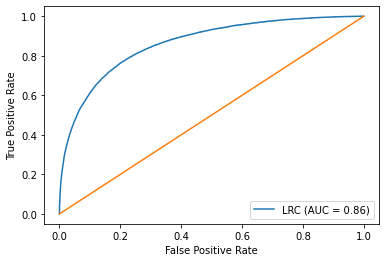

In [246]:
print(confusion_matrix(y_train,pipe_lrc.predict(X_train)))

print('ROC AUC =',roc_auc_score(y_train, pipe_lrc.predict_proba(X_train)[:,1]))
plot_roc_curve(pipe_lrc, X_train, y_train, name='LRC train')
plt.plot([0,1],[0,1])
plt.show()

### Em X_test

(Como o modelo generaliza nos exemplos de teste)

[[41853  3049]
 [ 2491  2607]]
ROC AUC = 0.8510730766461128


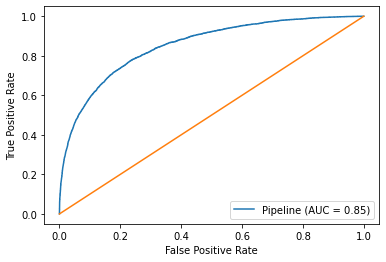

In [247]:
print(confusion_matrix(y_test, pipe_lrc.predict(X_test)))

print('ROC AUC =',roc_auc_score(y_test, pipe_lrc.predict_proba(X_test)[:,1]))
plot_roc_curve(pipe_lrc, X_test, y_test)
plt.plot([0,1],[0,1])
plt.show()

Pelos parâmetros que o GridSearch devolveu eu esperava que fosse overfittar, mas pelo visto não. Temos um bom score nos dados de teste.

## 4.2. Random Forest

Uma RandomForest é um comitê de árvores de decisão que dispensa maiores introduções.

In [206]:
rus = RandomUnderSampler(random_state=0)

rfc = RandomForestClassifier(random_state=0)

pipe_rfc = Pipeline([('rus', rus), ('rfc', rfc)])

params = {'rus__sampling_strategy': [1.,1/2,1/3],
          'rfc__max_depth': np.arange(3,13,4), #nao queremos arvores muito profundas
          'rfc__n_estimators': np.arange(100,201,100)
         }

search = GridSearchCV(estimator=pipe_rfc, param_grid=params, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

In [208]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  6.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rus',
                                        RandomUnderSampler(random_state=0)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=0))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': array([ 3,  7, 11]),
                         'rfc__n_estimators': array([100, 200]),
                         'rus__sampling_strategy': array([1.        , 0.5       , 0.33333333])},
             scoring='roc_auc', verbose=1)

In [222]:
pipe_rfc.set_params(**search.best_params_)
pipe_rfc.fit(X_train,y_train)

Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=0, sampling_strategy=1.0)),
                ('rfc',
                 RandomForestClassifier(max_depth=11, n_estimators=200,
                                        random_state=0))])

### Em X_train

[[106166  28834]
 [  1901  13099]]
ROC AUC = 0.9174366735802468


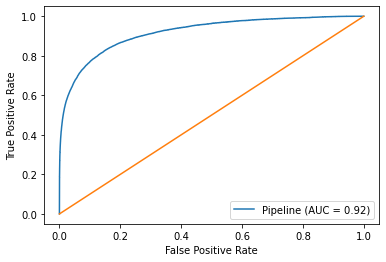

In [230]:
print(confusion_matrix(y_train,pipe_rfc.predict(X_train)))

print('ROC AUC =',roc_auc_score(y_train, pipe_rfc.predict_proba(X_train)[:,1]))
plot_roc_curve(pipe_rfc, X_train, y_train)
plt.plot([0,1],[0,1])
plt.show()

### Em X_test

[[34187 10715]
 [ 1402  3696]]
ROC AUC = 0.8206498100680407


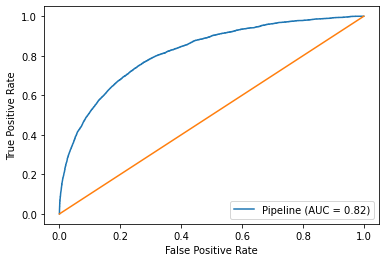

In [229]:
print(confusion_matrix(y_test,pipe_rfc.predict(X_test)))

print('ROC AUC =',roc_auc_score(y_test, pipe_rfc.predict_proba(X_test)[:,1]))
plot_roc_curve(pipe_rfc, X_test, y_test)
plt.plot([0,1],[0,1])
plt.show()

Ora, parece que estamos overfittando um pouquinho aqui. De qualquer forma, nos exemplos de teste a Regressão Logística segue tendo uma performance melhor.

## 4.3. XGBoost

XGBoost é um classificador que se utiliza da técnica de Gradient Boosting em uma RandomForest de árvores "fracas". A diferença deste para os comitês, em geral, é que aqui o primeiro classificador do comitê irá fornecer uma amostra com pesos diferentes para o segundo, e assim por diante. Esses pesos dependem dos erros do classificador.

In [22]:
rus = RandomUnderSampler(random_state=0)

xgbst = XGBClassifier(use_label_encoder=False, random_state=0) #sklearn wrapper

pipe_xgb = Pipeline([('rus', rus), ('xgbst', xgbst)])

params = {'rus__sampling_strategy': [1.,1/2],
          'xgbst__max_depth': [2,4],
          'xgbst__learning_rate': [0.3,0.6,1.],
          'xgbst__reg_lambda': [0.1, 1], #regularizacao \ell_2
          'xgbst__n_estimators': [100,300]
         }

search = GridSearchCV(estimator=pipe_xgb, param_grid=params, cv=3, scoring='roc_auc', n_jobs=6, verbose=1)

In [23]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 16.7min
[Parallel(n_jobs=6)]: Done 144 out of 144 | elapsed: 76.0min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rus',
                                        RandomUnderSampler(random_state=0)),
                                       ('xgbst',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='auc',
                                                      gamma=None, gpu_id=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                             

In [30]:
pipe_xgb.set_params(**search.best_params_)
pipe_xgb.fit(X_train,y_train)

Wall time: 3min 58s


Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.5)),
                ('xgbst',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               eval_metric='auc', gamma=0, gpu_id=-1,
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.3, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=0.1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_enco

### Em X_train

[[123699  11301]
 [   996  14004]]
ROC AUC = 0.9735113943209875


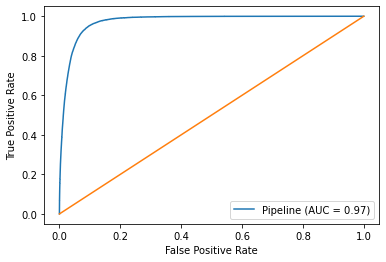

In [31]:
print(confusion_matrix(y_train,pipe_xgb.predict(X_train)))

print('ROC AUC =',roc_auc_score(y_train, pipe_xgb.predict_proba(X_train)[:,1]))
plot_roc_curve(pipe_xgb, X_train, y_train)
plt.plot([0,1],[0,1])
plt.show()

### Em X_test

[[40140  4762]
 [ 1688  3410]]
ROC AUC = 0.877288987346822


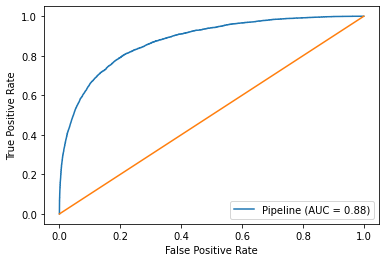

In [32]:
print(confusion_matrix(y_test,pipe_xgb.predict(X_test)))

print('ROC AUC =',roc_auc_score(y_test, pipe_xgb.predict_proba(X_test)[:,1]))
plot_roc_curve(pipe_xgb, X_test, y_test)
plt.plot([0,1],[0,1])
plt.show()

Houve uma melhora relativamente grande, se comparado à RandomForest. Podemos notar isso através das matrizes de confusão nos dados de teste, a quantidade de previsões corretas (True Positives) é quase igual, mas a quantidade de falsos positivos diminuiu para menos da metade.

## 4.4. LightGBM

Assim como o XGBoost, o LightGBM é uma implementação da técnica de Gradient Boosting para RandomForests fracas. A principal diferença entre os dois é a maneira como são construídas as árvores de decisão. No LightGBM, a construção é mais sofisticada e acaba sendo muito mais rápida.

In [40]:
rus = RandomUnderSampler(random_state=0)

lgbm = LGBMClassifier(random_state=0) #sklearn wrapper

pipe_lgbm = Pipeline([('rus', rus), ('lgbm', lgbm)])

params_lgbm = {'rus__sampling_strategy': [1.,1/2],
          'lgbm__num_leaves': [15,31,100], #num_leaves controla melhor do que max_depth aqui
          'lgbm__learning_rate': [0.1,0.5,1.],
          'lgbm__reg_lambda': [0., 1], #regularizacao \ell_2
          'lgbm__n_estimators': [100,200]
         }

search_lgbm = GridSearchCV(estimator=pipe_lgbm, param_grid=params_lgbm, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)

In [41]:
search_lgbm.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  9.4min
[Parallel(n_jobs=6)]: Done 216 out of 216 | elapsed: 13.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('rus',
                                        RandomUnderSampler(random_state=0)),
                                       ('lgbm',
                                        LGBMClassifier(random_state=0))]),
             n_jobs=6,
             param_grid={'lgbm__learning_rate': [0.1, 0.5, 1.0],
                         'lgbm__n_estimators': [100, 200],
                         'lgbm__num_leaves': [15, 31, 100],
                         'lgbm__reg_lambda': [0.0, 1],
                         'rus__sampling_strategy': [1.0, 0.5]},
             scoring='roc_auc', verbose=2)

In [43]:
search_lgbm.best_params_

{'lgbm__learning_rate': 0.1,
 'lgbm__n_estimators': 200,
 'lgbm__num_leaves': 31,
 'lgbm__reg_lambda': 1,
 'rus__sampling_strategy': 0.5}

In [42]:
pipe_lgbm.set_params(**search_lgbm.best_params_)
pipe_lgbm.fit(X_train,y_train)

Pipeline(steps=[('rus',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.5)),
                ('lgbm',
                 LGBMClassifier(n_estimators=200, random_state=0,
                                reg_lambda=1))])

### Em X_train

Accuracy = 0.9174
Precision = 0.5599
Recall (TPR) = 0.8116
1-Specificity (FPR) = 0.0709 

F1 score = 0.6627
F2 score = 0.744660 

F222 score = 0.744660 

ROC AUC = 0.9526


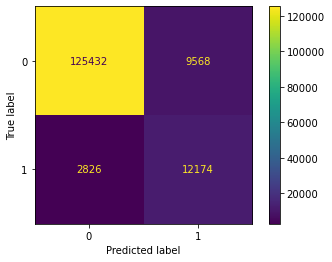

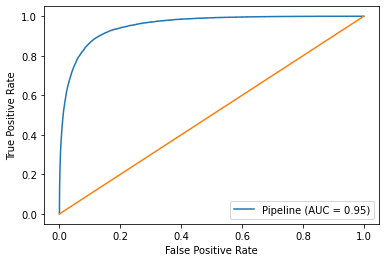

In [109]:
score_model(pipe_lgbm, X_train, y_train)

### Em X_test

Accuracy = 0.8866
Precision = 0.4584
Recall (TPR) = 0.6161
1-Specificity (FPR) = 0.0826 

F1 score = 0.5257
F2 score = 0.5765 

ROC AUC = 0.8789


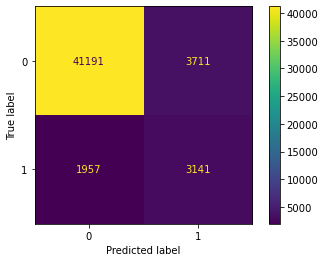

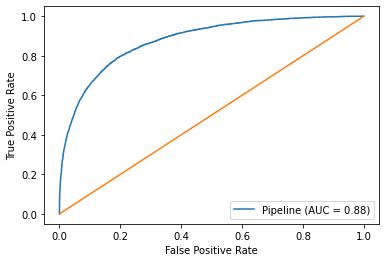

In [105]:
score_model(pipe_lgbm, X_test, y_test)

Aparentamos ter uma leve melhora, com relação ao XGBoost. Além disso, a diferença entre os tempos de treinamento é drástica. Vamos comparar as AUCs a seguir, mas até aqui tudo indica que este será o modelo escolhido.

# 5. Conclusões

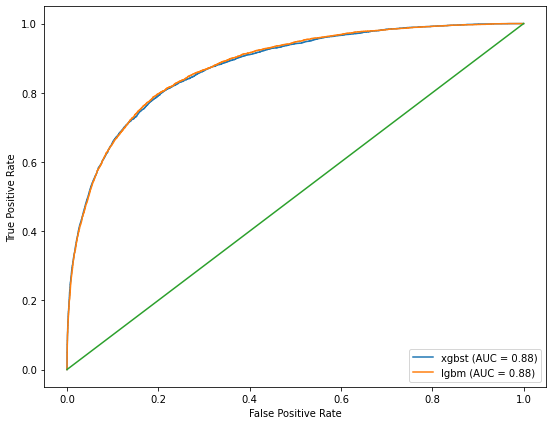

In [90]:
fig, ax = plt.subplots(figsize=(9,7))

#plot_roc_curve(pipe_lrc, X_test, y_test, name='lrc')
#plot_roc_curve(pipe_rfc, X_test, y_test, name='rfc')
plot_roc_curve(pipe_xgb, X_test, y_test, name='xgbst',ax=ax)
plot_roc_curve(pipe_lgbm, X_test, y_test, name='lgbm',ax=ax)
plt.plot([0,1],[0,1])
plt.show()

Embora cada um dos modelos seja um classificador binário, podemos enxergá-los como preditores de probabilidade. O método predict que usamos para calcular, por exemplo, o Recall classifica os exemplos de acordo com a probabilidade estimada pelo modelo, com um threshold de 0.5. Isto é, se a probabilidade de ser da classe 1 é menor que 0.5, então classificamos como 0.

Isso é interessante quando queremos uma estimativa razoável e rápida de como nosso modelo está performando. Entretanto, esse threshold influencia diretamente as outras métricas que, possivelmente, estaremos interessados em melhorar (como o F1 score).

Portanto, o modelo final será escolhido baseado nos hiperparâmetros que maximizam a ROC AUC (já fizemos isto) e, também, no threshold que maximiza uma métrica dependente de tal parâmetro. Sem mais informações sobre o modelo de negócios, não temos como saber os custos (ou lucros) associados a cada quadrante da matriz de confusão.

Podemos fazer uma análise mais qualitativa do problema e inferir que:

- Estamos interessados em prever a classe minoritária 1, ou seja, queremos um Recall bom.
- Não seria muito prejudicial prever um exemplo da classe 0 como 1 (FP), entretanto seria bom minimizar essas ocorrências também. Isto é, queremos uma Precision boa, mas reconhecemos que o Recall seja mais importante.

Assim, faz sentido escolher a métrica F2 como candidata pra tunar nosso threshold, pois esta é a média harmônica entre Precision e Recall, atribuindo um peso 2 ao Recall.

In [146]:
#funcao auxiliar
def optimal_threshold_score(metric, estimator, X, y_true):
    y_proba = estimator.predict_proba(X)
    
    thresholds = np.linspace(0, 1, 1000)
    
    y_pred = lambda t : np.where(y_proba >= t, 1, 0)[:,1]
    
    scores = np.array([metric(y_true, y_pred(t)) for t in thresholds])
    
    opt_threshold = np.argmax(scores)/1000
    
    print('Optimal threshold =', opt_threshold)
    
    plt.plot(thresholds, scores)
    plt.axvline(opt_threshold, linestyle='--', color='red')
    plt.ylabel('Score')
    plt.xlabel('thresholds')
    plt.show()
    
    return scores.max()

Optimal threshold = 0.325


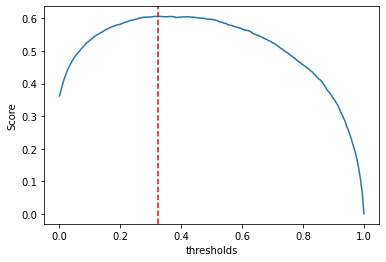

XGBoost F2 score = 0.6065275680340247
Optimal threshold = 0.377


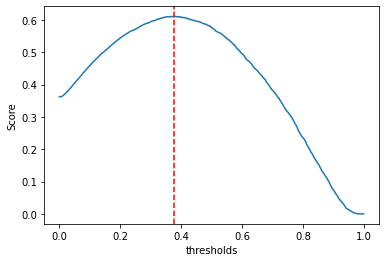

LightGBM F2 score = 0.611410050662387


In [150]:
f2score = lambda y_true, y_pred : fbeta_score(y_true, y_pred, beta=2)
# print('LR F2 score =', optimal_threshold_score(f2score, pipe_lrc, X_test, y_test))
# print('RandomForest F2 score =', optimal_threshold_score(f2score, pipe_rfc, X_test, y_test))
print('XGBoost F2 score =', optimal_threshold_score(f2score, pipe_xgb, X_test, y_test))
print('LightGBM F2 score =', optimal_threshold_score(f2score, pipe_lgbm, X_test, y_test))

In [151]:
# y_predict=np.where(pipe_lgbm.predict_proba(X_test) >= threshold, 1, 0)[:,1]

# print('Scores para o novo threshold\n')
    
# print('Accuracy =', '%.4f' % accuracy_score(y_test, y_predict))
# print('Precision =', '%.4f' % precision_score(y_test, y_predict))
# print('Recall (TPR) =', '%.4f' % recall_score(y_test, y_predict))
# print('1-Specificity (FPR) =', '%.4f' % (1-recall_score(y_test, y_predict, pos_label=0)), '\n')

# print('F1 score =', '%.4f' % f1_score(y_test, y_predict))
# print('F2 score =', '%.4f' % fbeta_score(y_test, y_predict,beta=2), '\n')

# ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_predict)).plot()
# plt.show()

Portanto, o modelo de predição escolhido será o LightGBM, treinado como pipe_lgbm e com threshold t = 0.377. Este possui uma ROC AUC de 0.8789 nos dados de teste e um F2 score de 0.6114 associado ao threshold t.